# Preprocessing générique des images

## Utilisable avec toutes les libs

### Permet d'obtenir un dossier "balanced_image_train" avec:
- 1000 images par catégories (27)
- des traitements pour 30% d'entre elles : flip horiziontal / vertical, zoom, brightness

In [32]:
import os
import shutil
import random
from PIL import Image, ImageEnhance
from sklearn.utils import resample
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# options d'affichage
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [12]:
# Import du dataframe qui contient les références images

data = pd.read_csv('img-data.csv')
data.head()

print("Répartition des catégories\n:", data['prdtypecode'].value_counts())

Répartition des catégories
: prdtypecode
2583    10209
1560     5073
1300     5045
2060     4993
2522     4989
1280     4870
2403     4774
2280     4760
1920     4303
1160     3953
1320     3241
10       3116
2705     2761
1140     2671
2582     2589
40       2508
2585     2496
1302     2491
1281     2070
50       1681
2462     1421
2905      872
60        832
2220      824
1301      807
1940      803
1180      764
Name: count, dtype: int64


In [14]:
# Sampling des images (1000 img par catégorie)

data_sampled = data.groupby('prdtypecode').apply(lambda x: x.sample(n = min(1000, len(x)), random_state = 42)).reset_index(drop = True)
print(data_sampled['prdtypecode'].value_counts())


prdtypecode
10      1000
40      1000
2705    1000
2585    1000
2583    1000
2582    1000
2522    1000
2462    1000
2403    1000
2280    1000
2060    1000
1920    1000
1560    1000
1320    1000
1302    1000
1300    1000
1281    1000
1280    1000
1160    1000
1140    1000
50      1000
2905     872
60       832
2220     824
1301     807
1940     803
1180     764
Name: count, dtype: int64


In [22]:
# Data augmentation

def img_augmentation(image):
    """
    - desc: Applique plusieurs opérations de transformation à une image, aléatoirement
    - vparams: img - image a traiter
    - returns: image traitée
    """

    # Rotation
    if random.random() > 0.5:
        image = image.rotate(random.uniform(-30, 30))
    
    # Zoom
    if random.random() > 0.5:
        zoom_factor = random.uniform(0.8, 1.2)
        width, height = image.size
        x = int((width * zoom_factor - width) / 2)
        y = int((height * zoom_factor - height) / 2)
        image = image.crop((x, y, width - x, height - y))
        image = image.resize((width, height), Image.Resampling.LANCZOS)
    
    # Flip horizontal
    if random.random() > 0.5:
        image = image.transpose(Image.FLIP_LEFT_RIGHT)

    # Flip vertical
    if random.random() > 0.5:
        image = image.transpose(Image.FLIP_TOP_BOTTOM)
    
    # Brightness
    if random.random() > 0.5:
        enhancer = ImageEnhance.Brightness(image)
        image = enhancer.enhance(random.uniform(0.7, 1.3))
    
    return image


In [23]:
def copy_and_resample_images(group, augment_percentage=0.3):
    """
    - desc : Oversample les images d'un prdtypecode, les copie dans le dossier "balanced_dir"
    avec des noms uniques et applique des augmentations de données sur un pourcentage donné.
    - group : lignes d'images pour un prdtypecode donné
    - augment_perc : pourcentage d'images qui recevront un traitement d'augmentation
    """

    balanced_dir = '../../data/images/balanced_image_train'
    os.makedirs(balanced_dir, exist_ok = True)

    # Oversampling pour atteindre max_samples
    max_samples = 1000
    resampled_group = resample(group, replace = True, n_samples = max_samples, random_state=42)
    
    # Nouveaux paths img
    new_paths = []
    
    # Compteur pour générer copies des img
    copy_counters = {}
    
    for index, row in resampled_group.iterrows():
        src = os.path.join('../../data/images/image_train', row['image name'])
        dst_dir = os.path.join(balanced_dir, str(row['prdtypecode']))
        os.makedirs(dst_dir, exist_ok=True)
        
        # nom de fichier avec / sans extension
        file_name, file_ext = os.path.splitext(os.path.basename(row['image name']))
        
        # MAJ du compteur pour l'image
        if row['image name'] not in copy_counters:
            copy_counters[row['image name']] = 1
        else:
            copy_counters[row['image name']] += 1
        
        # Création nom fichier unique
        unique_suffix = f"_{copy_counters[row['image name']]}"
        unique_file_name = f"{file_name}{unique_suffix}{file_ext}"
        
        dst = os.path.join(dst_dir, unique_file_name)
        
        # img loading
        image = Image.open(src)
        
        # data augmentation
        if random.random() < augment_percentage:
            image = img_augmentation(image)
        
        # img save
        image.save(dst)
        
        # MAJ new_path avec nouveau path créé
        new_paths.append(os.path.relpath(dst, start='../../data/images'))
    
    # MAJ dataframe
    resampled_group['image name'] = new_paths
    
    return resampled_group


In [24]:
data_balanced = data_sampled.groupby('prdtypecode').apply(copy_and_resample_images).reset_index(drop=True)
print(data_balanced.head())
print(data_balanced['image name'].unique())

                                         designation  \
0  La Lorraine Insolite   de LECLERC (L. Charles)...   
1  Lettre Encyclique Casti Connubii Sur Le Mariag...   
2             Gentleman: A Timeless Guide To Fashion   
3              Catalogue Illustré De Livres Modernes   
4                     Rudolph Leopold : Art Director   

                        description   productid     imageid  \
0                               NaN   122807122   900334088   
1                               NaN   984922418  1052423013   
2  Overview not currently available   121043396   875123391   
3                               NaN    69462253   875859855   
4                               NaN  2014805058  1268253771   

                                          image name  image size in bits  \
0  balanced_image_train\10\image_900334088_produc...               19551   
1  balanced_image_train\10\image_1052423013_produ...               28397   
2  balanced_image_train\10\image_875123391_produc...    

In [27]:

data_balanced.head()

designation  \
0  La Lorraine Insolite   de LECLERC (L. Charles)...   
1  Lettre Encyclique Casti Connubii Sur Le Mariag...   
2             Gentleman: A Timeless Guide To Fashion   
3              Catalogue Illustré De Livres Modernes   
4                     Rudolph Leopold : Art Director   

                        description   productid     imageid  \
0                               NaN   122807122   900334088   
1                               NaN   984922418  1052423013   
2  Overview not currently available   121043396   875123391   
3                               NaN    69462253   875859855   
4                               NaN  2014805058  1268253771   

                                          image name  image size in bits  \
0  balanced_image_train\10\image_900334088_produc...               19551   
1  balanced_image_train\10\image_1052423013_produ...               28397   
2  balanced_image_train\10\image_875123391_produc...                9004   
3  balanced_image_train\10\image_875859855_produc...               20816   
4  balanced_image_train\10\image_1268253771_produ...               41950   

   prdtypecode      désignation textuelle catégorie niv 1  
0           10  Livres anciens / occasion     Littérature  
1           10  Livres anciens / occasion     Littérature  
2           10  Livres anciens / occasion     Littérature  
3           10  Livres anciens / occasion     Littérature  
4           10  Livres anciens / occasion     Littérature

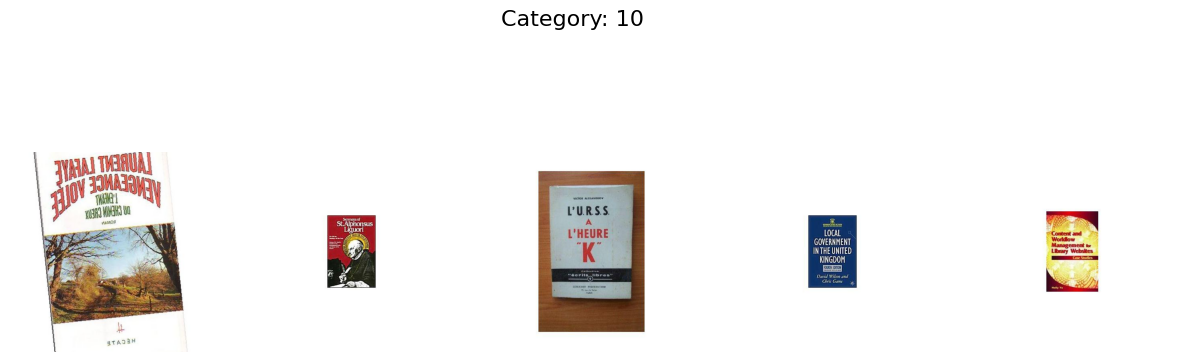

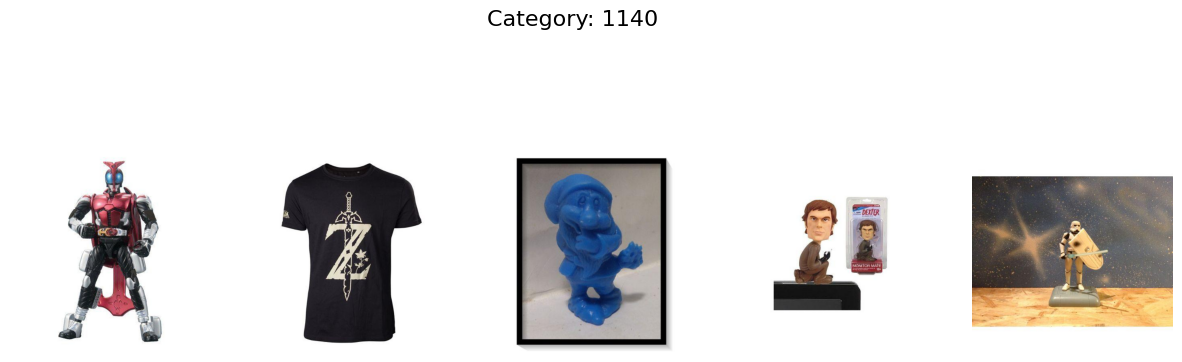

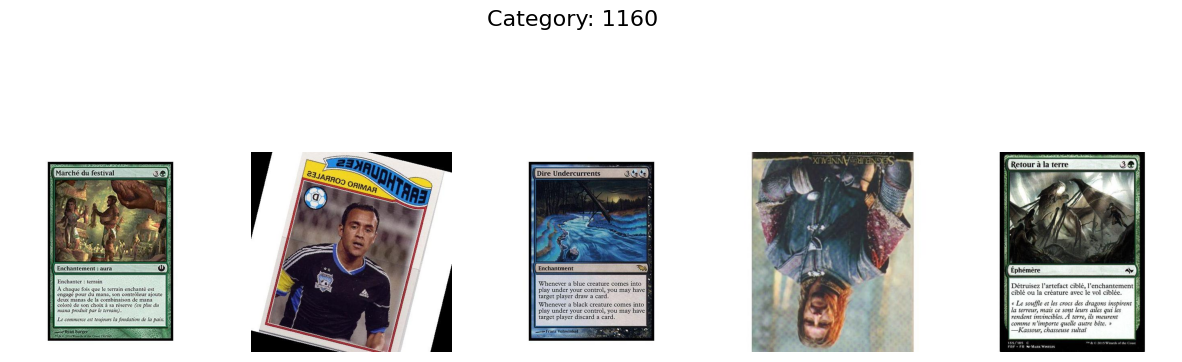

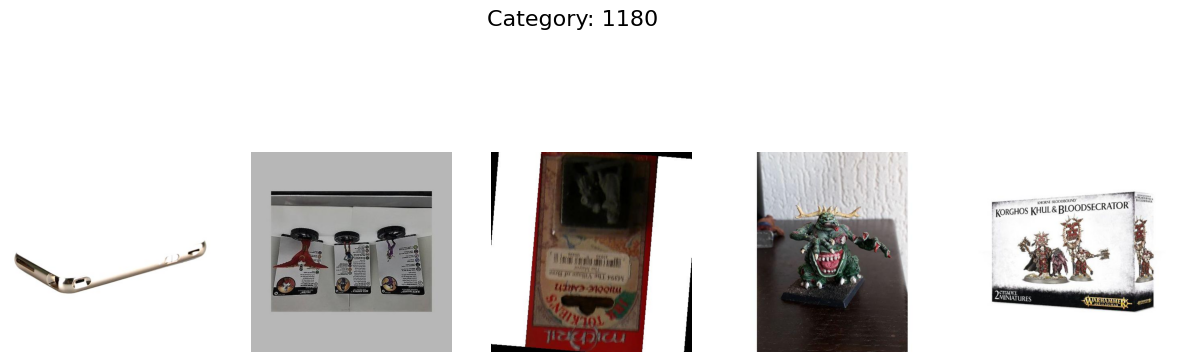

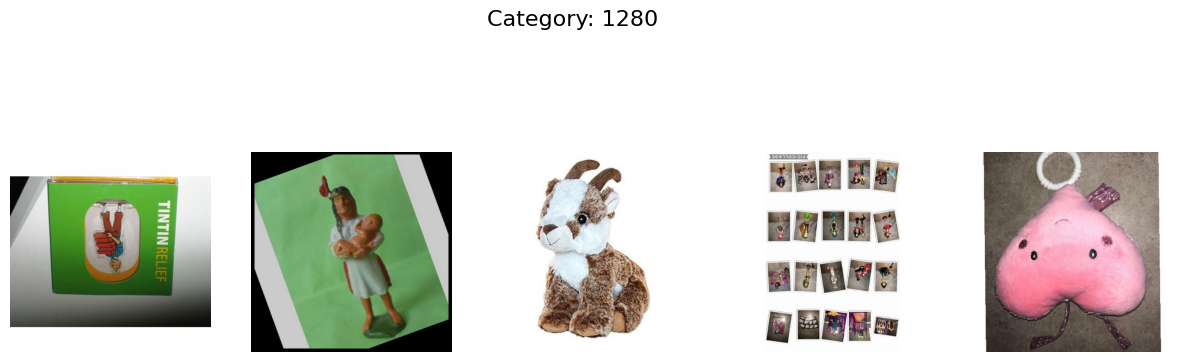

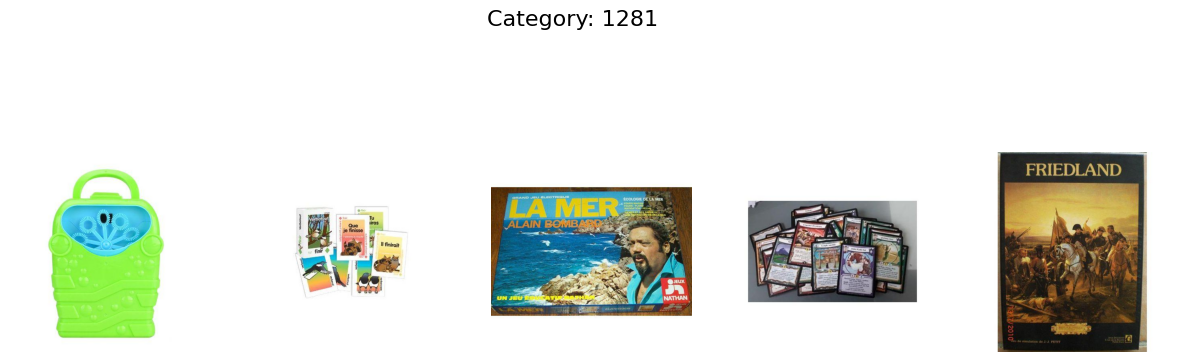

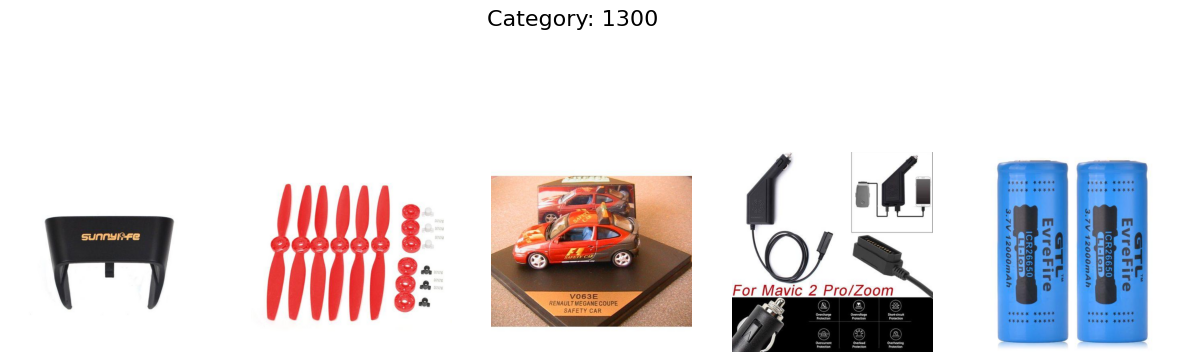

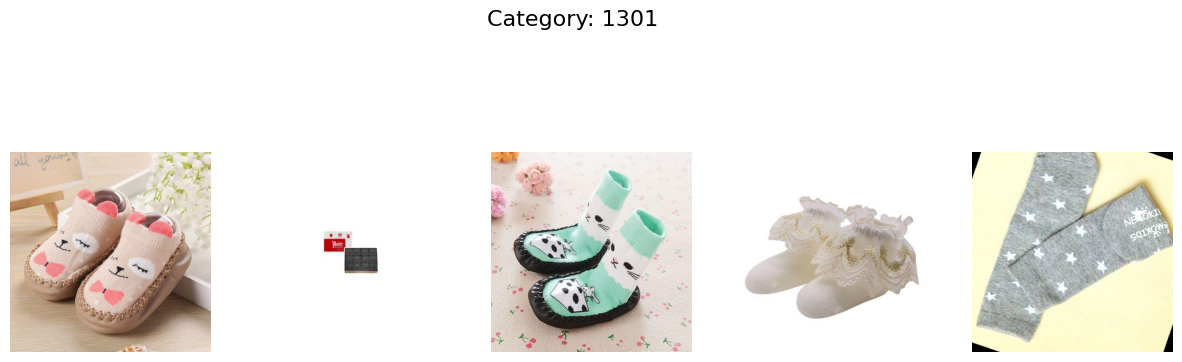

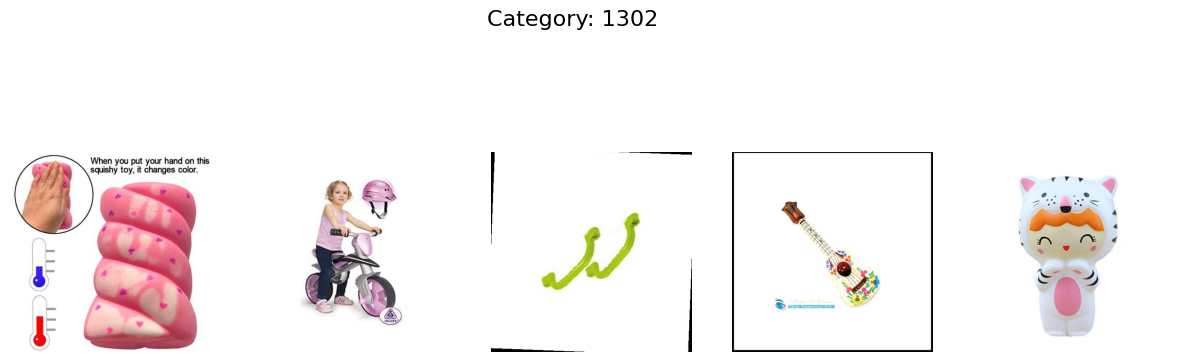

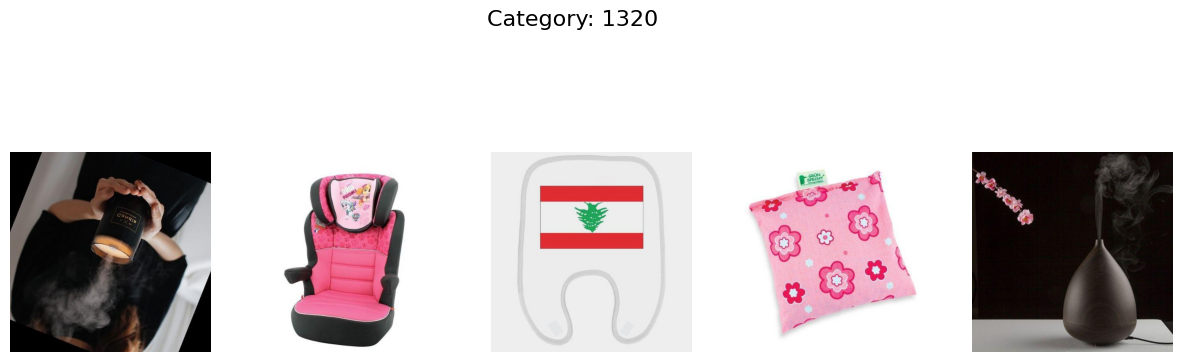

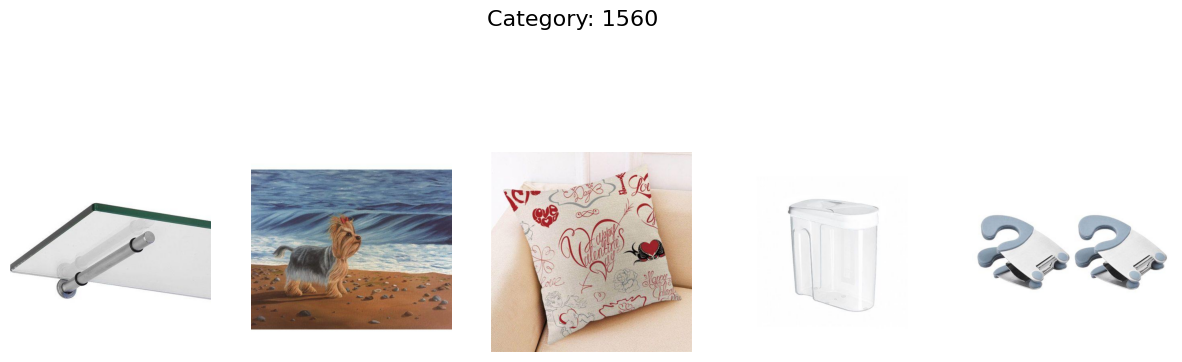

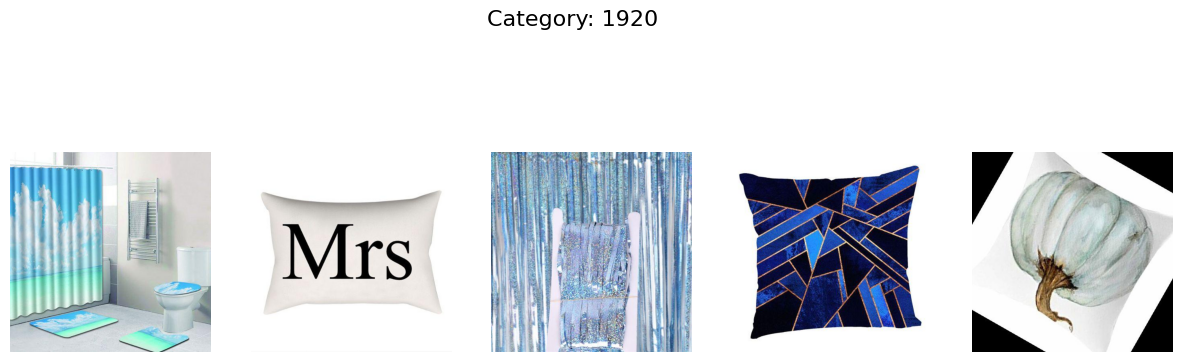

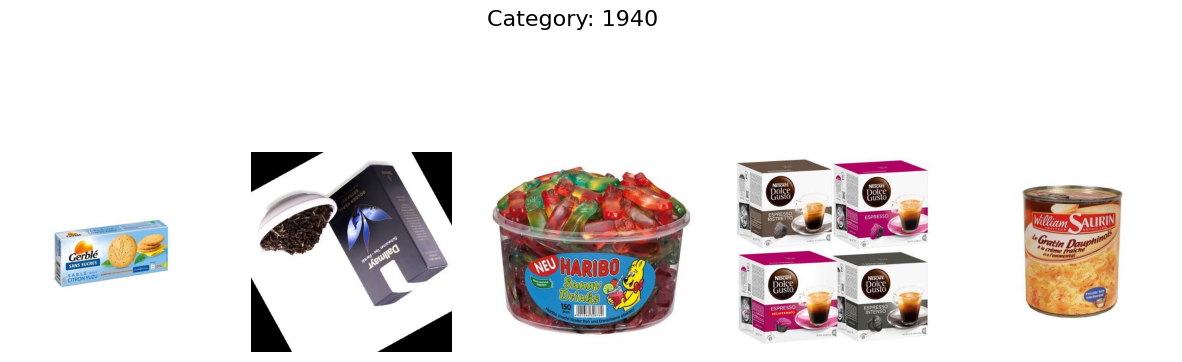

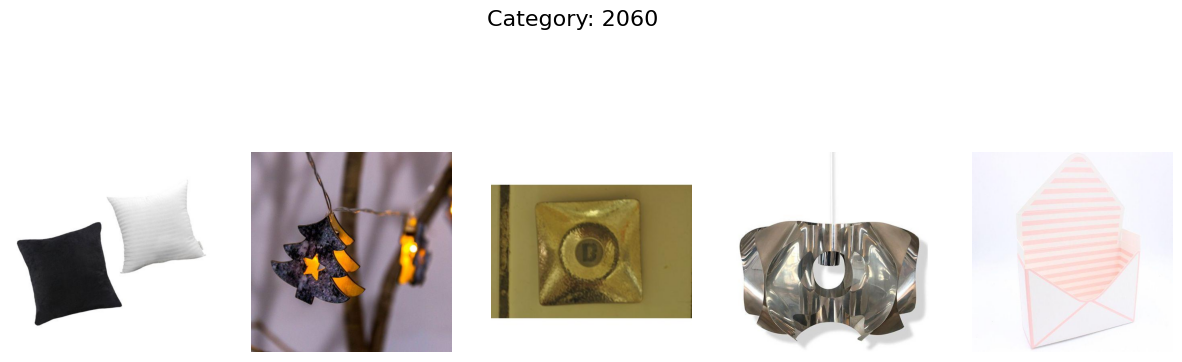

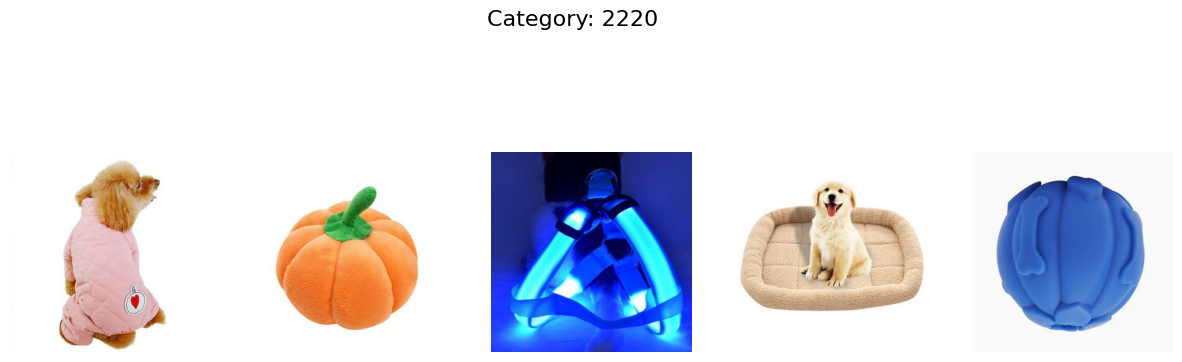

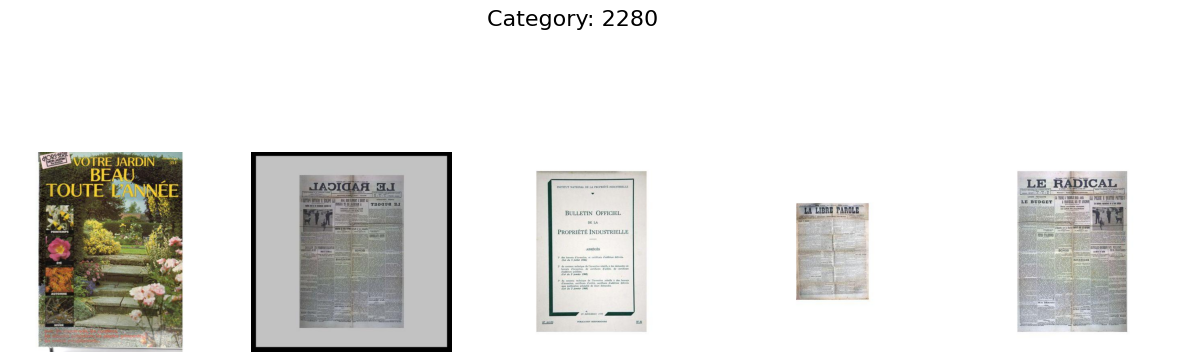

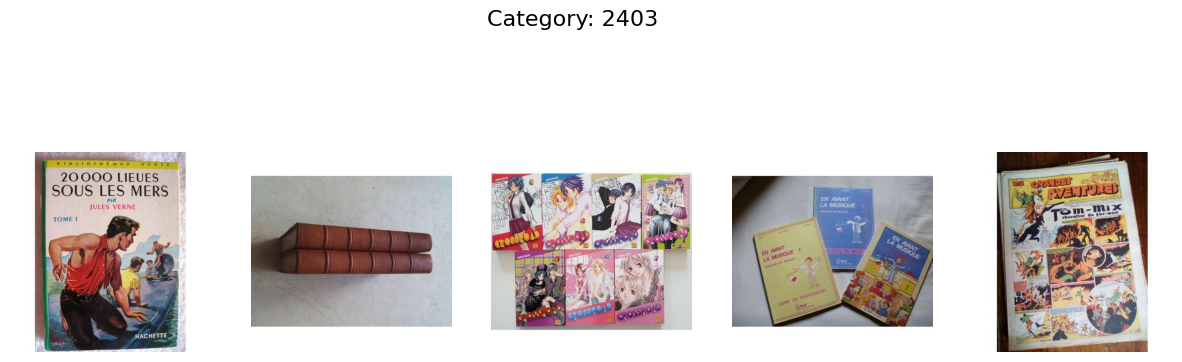

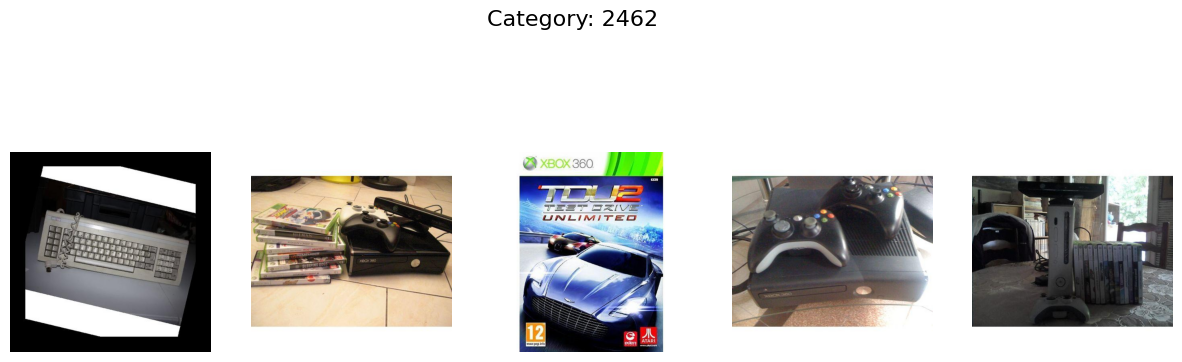

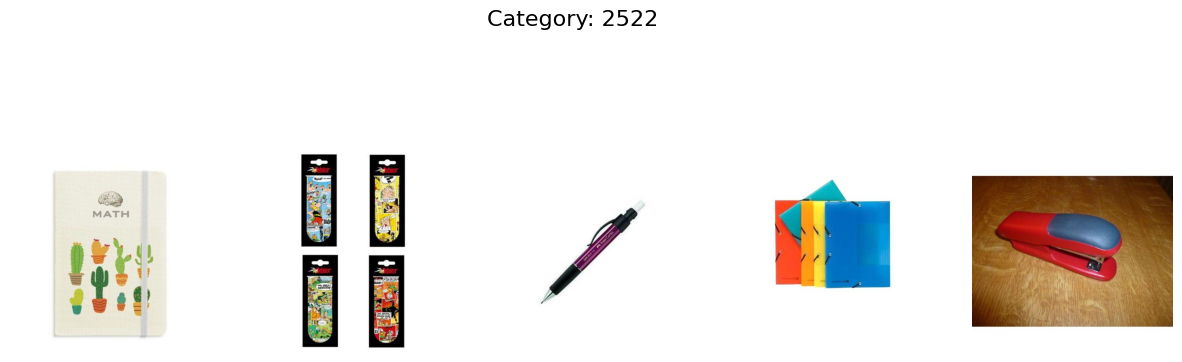

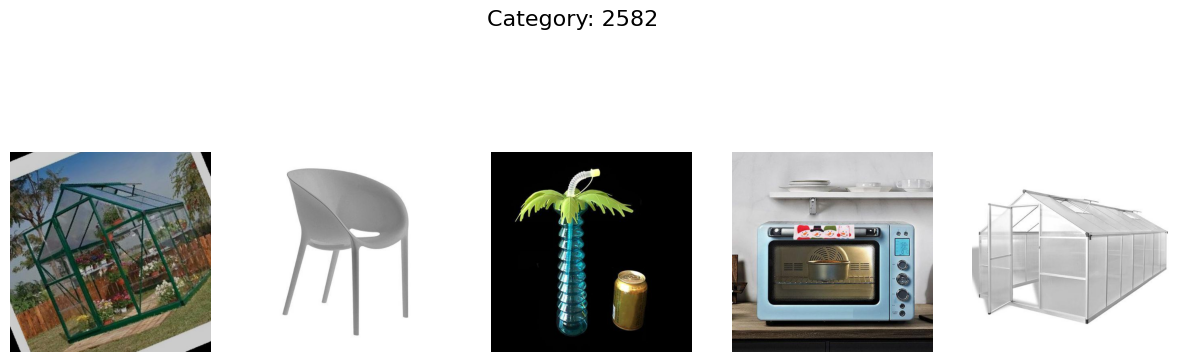

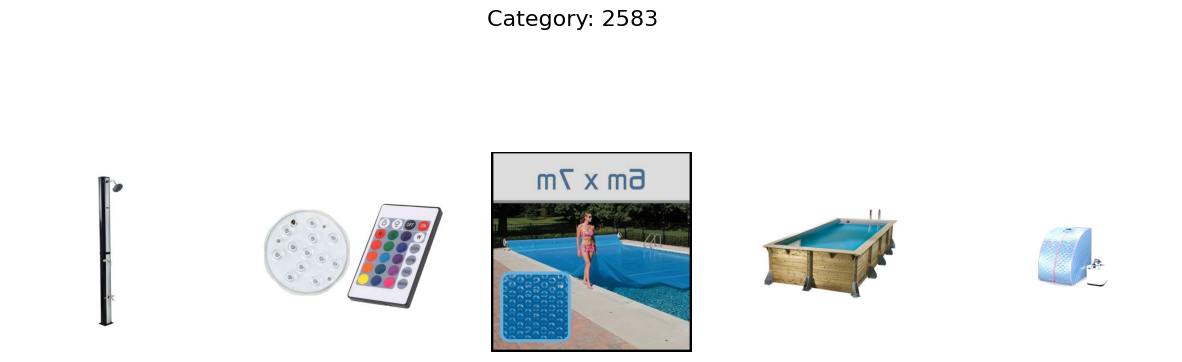

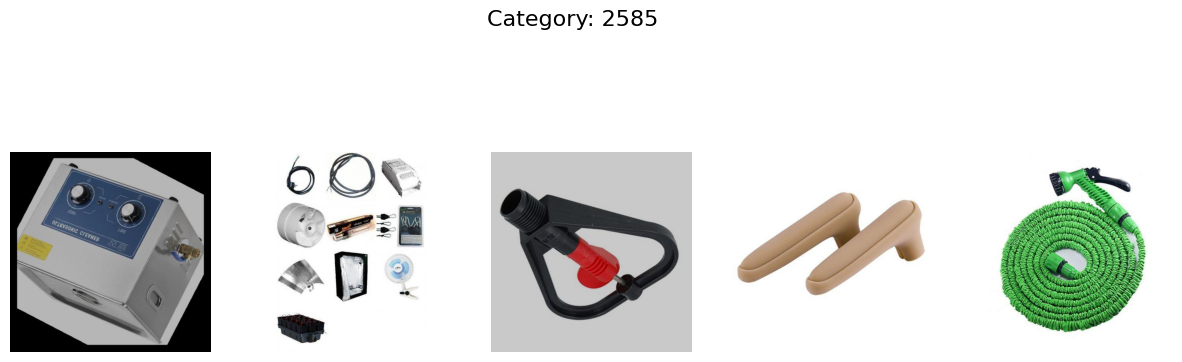

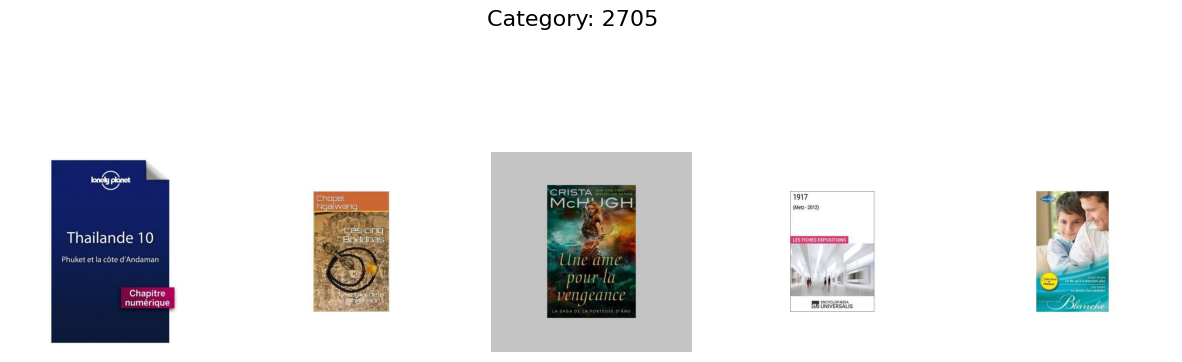

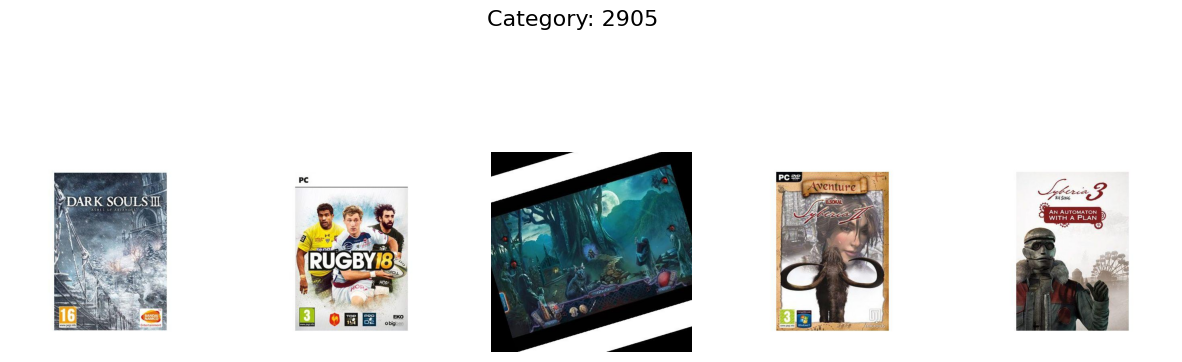

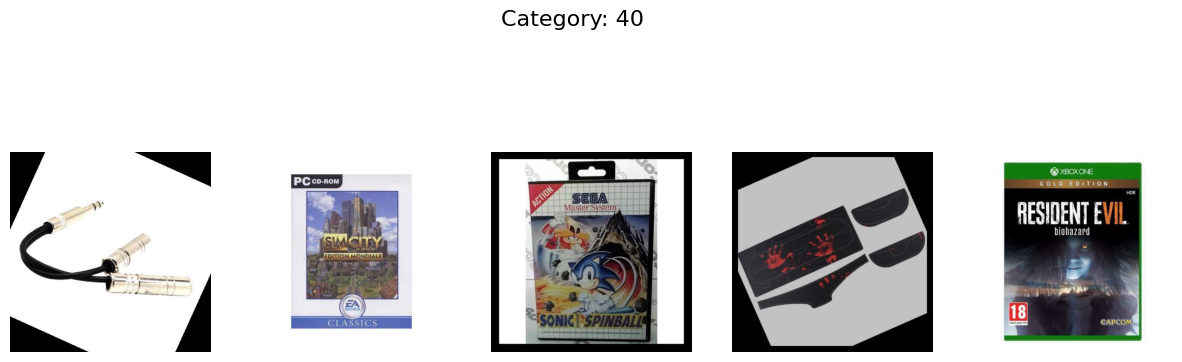

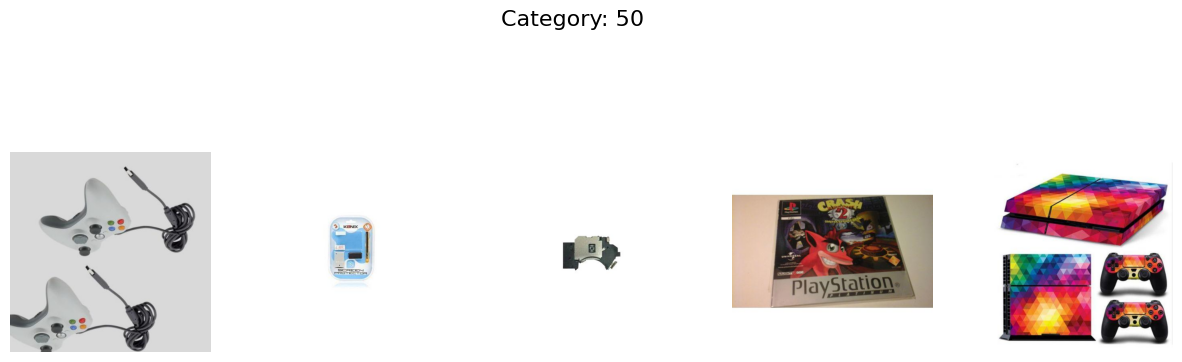

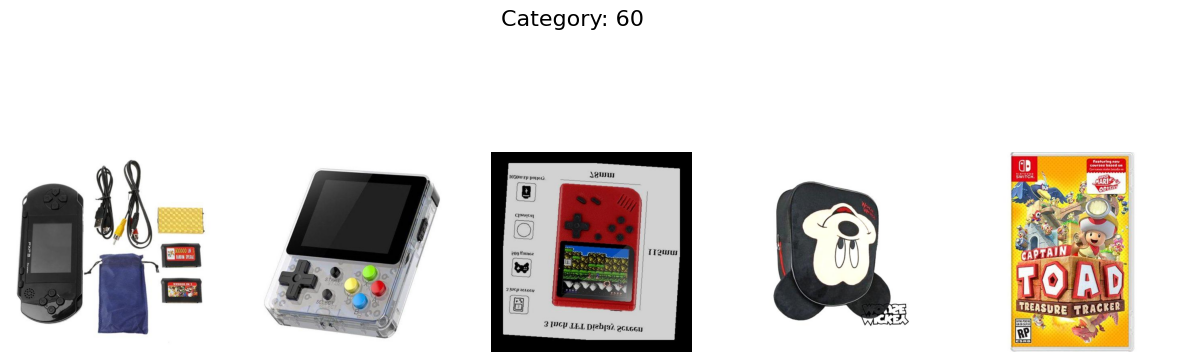

In [31]:
def show_images_per_category(base_dir, num_images = 5):
    """
    - desc : Affiche un nombre donné d'images par catégorie à partir du dossier de base.
    - params:
     -> base_dir : dossier de base
     -> num_images : nombre d'images à afficher par catégorie
    """

    # dict "prdtypecode -> désignation textuelle"
    category_to_text = dict(zip(data['prdtypecode'], data['désignation textuelle']))

    # parcours chaque dossier (cat) dans base_dir
    for category in os.listdir(base_dir):
        category_dir = os.path.join(base_dir, category)
        
        if os.path.isdir(category_dir):
            # liste des images du dossier
            image_files = os.listdir(category_dir)
            # sélection aléatoire de num_images
            selected_images = random.sample(image_files, min(num_images, len(image_files)))
            # designation textuelle de la categorie
            text_designation = category_to_text.get(int(category), "Unknown")
            # Affichage
            plt.figure(figsize=(15, 5))
            plt.suptitle(f"Category: {category} - {text_designation}", fontsize=16)
            
            for i, image_file in enumerate(selected_images):
                img_path = os.path.join(category_dir, image_file)
                img = Image.open(img_path)
                
                plt.subplot(1, num_images, i + 1)
                plt.imshow(img)
                plt.axis('off')
            
            plt.show()

# Spécifier le répertoire de base
balanced_dir = '../../data/images/balanced_image_train'

# Appeler la fonction pour afficher les images
show_images_per_category(balanced_dir, num_images=5)

